In [1]:
import os

import numpy as np
import datajoint as dj
import seaborn as sns
from matplotlib import pyplot as plt

# Data Base

In [2]:
from IPython.display import clear_output

from djimaging.user.alpha.utils import database

# Choose indicator by uncommenting one of the following lines
indicator = 'calcium'
# indicator = 'glutamate'

database.connect_dj(indicator=indicator)
clear_output()

## Get data

In [3]:
cell_tab = database.get_experiment_tab()
field_tab = database.get_field_tab()
morph_tab = database.get_morph_tab(quality_filter=True)

# Plot

In [4]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')
FIGURE_FOLDER = 'figures'

In [5]:
from djimaging.utils import scanm_utils
from matplotlib.colors import LinearSegmentedColormap

In [6]:
max_col = ()

dx_um = 25
dz_um = 10
locs = ['n', 'd', 't'] if indicator.startswith('ca') else ['n', 't']
n_max = 7
n_cells = 6 if indicator.startswith('ca') else 7

## Somas

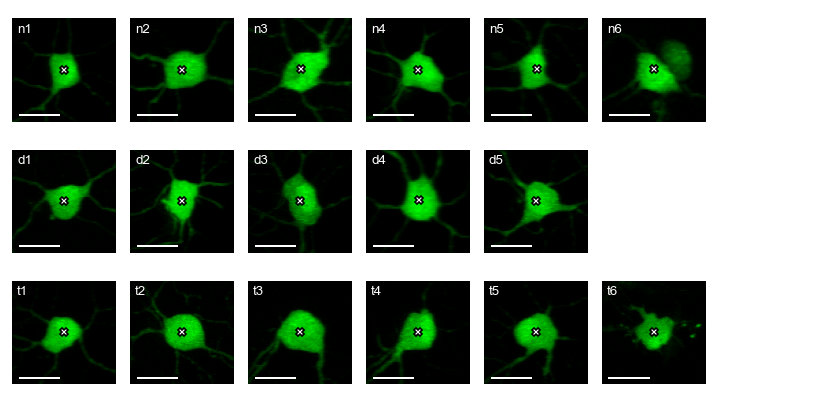

In [7]:
cm = LinearSegmentedColormap.from_list('cmap', [(0, 0, 0), 'lime' if indicator.startswith('ca') else 'magenta'], N=100)
ch_name = 'wDataCh0' if indicator.startswith('ca') else 'wDataCh1'

fig, axs = plt.subplots(len(locs), n_max, figsize=(7, len(locs) * 1.1 + 0.1))

for i, loc in enumerate(locs):
    for j, num in enumerate(range(1, n_max + 1)):
        try:
            key = ((field_tab & "field='stack'") & (cell_tab & f"cell_tag='{loc}{num}'")).fetch1('KEY')
        except dj.DataJointError:
            continue

        stack_file = (field_tab & key).fetch1('fromfile')

        ch_stacks, wparams = scanm_utils.load_stacks_from_h5(stack_file)

        soma_xyz = (morph_tab & key).fetch1('soma_xyz')
        pixel_size_um = (field_tab & key).fetch1('pixel_size_um')
        z_step_um = (field_tab & key).fetch1('z_step_um')
        tag = (cell_tab & key).fetch1('cell_tag')

        soma_x_px = int(np.round(soma_xyz[0] / pixel_size_um))
        soma_y_px = int(np.round(soma_xyz[1] / pixel_size_um))
        soma_z_px = int(np.round(soma_xyz[2] / z_step_um))

        dx = int(np.round(dx_um / pixel_size_um))
        dz = int(np.round(dz_um / z_step_um))

        soma_stack = np.max(ch_stacks[ch_name][soma_x_px - dx:soma_x_px + dx, soma_y_px - dx:soma_y_px + dx,
                            soma_z_px - dz:soma_z_px + dz], axis=-1).T

        # Plot
        ax = axs[i, j]
        ax.imshow(soma_stack, origin='lower', cmap=cm)
        ax.plot(dx, dx, 'X', mec='k', mfc='w')

        plota.plot_scale_bar(ax, x0=3 / pixel_size_um, y0=3 / pixel_size_um, size=20 / pixel_size_um, color='w')
        ax.text(0.05, 0.95, tag, transform=ax.transAxes, c='w', ha='left', va='top')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()

plt.savefig(os.path.join(FIGURE_FOLDER, f'somas_{indicator}.pdf'))
plt.show()

## Stratification

In [8]:
from morphopy.computation import file_manager as fm
from morphopy.computation.feature_presentation import compute_density_maps

from alphaanalysis.plot import plot_paths

In [9]:
zdepths = (np.arange(723) * .00194286 - 0.200914)  # Eyewire depths

In [10]:
bins = zdepths.size
zmin = zdepths.min()
zmax = zdepths.max()
bin_centers = np.linspace(zmin, zmax, bins, endpoint=True)

In [11]:
morph_data = dict()

In [12]:
from alphaanalysis.morphkit import Morph


def load_cell(key):
    global morph_data

    stack_h5_file = (field_tab & key).fetch1('fromfile')
    outputdir = os.path.dirname(stack_h5_file.replace('/Pre/', '/Morph/'))
    swc_path_flat = os.path.join(outputdir, 'morph_flat.swc')

    m = Morph(filepath=swc_path_flat)
    df = m.df_paths
    if np.any(df.type == 1):
        soma_xyz = df[df.type == 1].path.iloc[0].flatten()
    else:
        soma_xyz = df.path.iloc[0].flatten()

    N = fm.load_swc_file(swc_path_flat)
    D = N.get_dendritic_tree()

    config = {'n_bins_x': 5, 'n_bins_x': 5, 'n_bins_z': bins, 'smooth': False, 'r_min_z': zmin - soma_xyz[2],
              'r_max_z': zmax - soma_xyz[2]}
    densities_maps = compute_density_maps(D, config)

    z_proj = densities_maps['z_proj']['data']
    morph_data[stack_h5_file] = (df.path, soma_xyz, z_proj)

In [13]:
from tqdm.notebook import tqdm
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    for key in tqdm(((field_tab & cell_tab) & "field='stack'").fetch('KEY')):
        load_cell(key)

  0%|          | 0/17 [00:00<?, ?it/s]

In [14]:
def plot_morph_xz(ax, paths, soma_xyz):
    plot_paths(ax, paths=paths, i1=0, i2=2, offset=[-soma_xyz[0], -soma_xyz[2], 0], lw=0.5, alpha=0.8)
    ax.set_yticks((0, 1))
    #ax.set_xlim(-200, 200)
    ax.set_ylim(-0.3, 1.1)
    ax.set_xticks([])
    plota.plot_scale_bar(ax=ax, x0=-50, y0=-0.2, size=100)


def plot_density(ax, z_proj, bin_centers, c='dimgray', alpha=0.9, lw=0.2):
    # 0 and 1 are flipped in EyeWire vs. our definition
    ax.plot(z_proj, bin_centers, c=c, alpha=alpha, lw=lw)
    ax.set_yticks((0, 1), labels=(1, 0))
    ax.set_xticks([])
    ax.set_xlim(-0.2, 12)


def add_hlines(ax):
    # 0 and 1 are flipped in EyeWire vs. our definition
    ax.axhline(0, c='r', ls='--')
    ax.axhline(0.38, c='darkred', ls='--')
    #ax.axhline(0.53, c='r', ls='--')
    #ax.axhline(0.72, c='gray', ls='--')
    ax.axhline(1, c='r', ls='--')

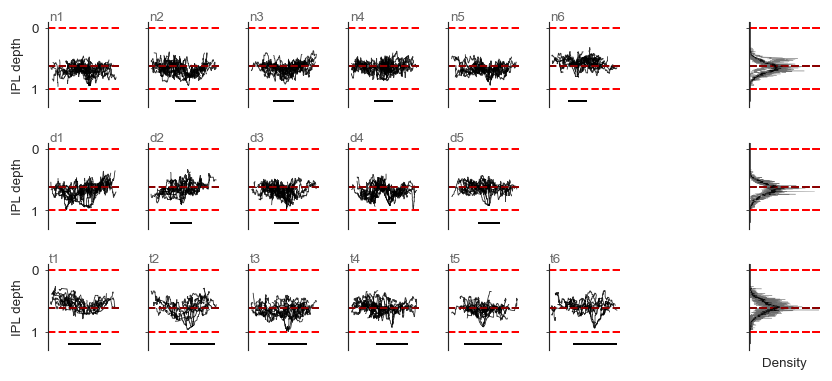

In [15]:
fig, axs = plt.subplots(len(locs), n_max + 1, figsize=(7, len(locs) * 1.1 + 0.1), sharey='all')

sns.despine(bottom=True)

axs_dens = axs[:, -1]

for i, loc in enumerate(locs):
    group_z_proj = []
    for j, num in enumerate(range(1, n_max + 1)):
        try:
            key = ((field_tab & "field='stack'") & (cell_tab & f"cell_tag='{loc}{num}'")).fetch1('KEY')
        except dj.DataJointError:
            axs[i, j].axis('off')
            continue

        stack_h5_file = (field_tab & key).fetch1('fromfile')

        try:
            paths, soma_xyz, z_proj = morph_data[stack_h5_file]
        except KeyError:
            print(f'WARNING: File not loaded {stack_h5_file}')
            continue

        group_z_proj.append(z_proj)

        # Plot
        ax = axs_dens[i]
        plot_density(ax, z_proj, bin_centers)
        add_hlines(ax)

        ax = axs[i, j]
        plot_morph_xz(ax, paths, soma_xyz)
        add_hlines(ax)
        ax.text(0.02, 1 - 0.02, f"{loc}{num}", transform=ax.transAxes, horizontalalignment='left',
                verticalalignment='bottom', c='dimgray', fontsize=8)

    ax = axs_dens[i]
    plot_density(ax, np.mean(np.array(group_z_proj), axis=0), bin_centers, c='k')

axs_dens[-1].set_xlabel('Density')
plt.tight_layout()

for ax in axs[:, 0]:
    ax.set_ylabel('IPL depth')

plt.savefig(os.path.join(FIGURE_FOLDER, f'dendrite_IPL_densities_{indicator}.pdf'))
plt.show()

## True somatic responses vs. proximal dendrites

In [16]:
if indicator != 'calcium':
    raise NotImplementedError

In [17]:
import pingouin as pg

def plot_scatter_and_reg(ax, xs, ys, cs, ms, labels):
    x_all = np.concatenate(xs)
    y_all = np.concatenate(ys)
    test = pg.corr(x_all, y_all, method='pearson')
    display(test)
    r_stat = test.loc['pearson', 'r']

    sns.regplot(ax=ax, x=x_all, y=y_all, line_kws=dict(color='k', zorder=-20), ci=None, robust=False, scatter=False)
    for x, y, c, m, label in zip(xs, ys, cs, ms, labels):
        sns.scatterplot(ax=ax, x=x, y=y, c=c, edgecolor='dimgray', marker=m, clip_on=False, s=9, label=label)

    ax.legend(
        handletextpad=-0.1,  # Reduce space between marker and text
        labelspacing=-0.1, bbox_to_anchor=(0.7, 1.2), loc='upper left')

    ax.set(title=f'r={r_stat:.2f}')

In [18]:
def plot_avg(ax, avg, avg_t, y0, color, cc=None):
    base = np.median(avg[avg_t < 2])
    avg_norm = (avg - base)
    avg_norm /= np.max(np.abs(avg_norm))

    ax.fill_between(avg_t, np.full_like(avg_norm, y0), y0 + avg_norm, color=color, alpha=0.5, linewidth=0,
                    clip_on=False)
    ax.plot(avg_t, y0 + avg_norm, color=color, alpha=1.0, lw=0.8, clip_on=False)
    if cc is not None:
        ax.text(np.max(field_avg_t) * 1.01, y0, fr'$\rho$={cc:.2f}', va='center')

In [19]:
from matplotlib.colors import ListedColormap

hspace = -1.2

stim_name = 'lChirp'
cc_dict = {}
dist_dict = {}
snr_dict = {}
tag_dict = {}

for i in [2, 0, 1]:  # Last one is plotted as traces
    soma_key = (RoiKind & dict(roi_kind='soma')).fetch('KEY')[i]

    field_key = soma_key.copy()
    field_key['field'] = soma_key['field'].replace('TrueSomaROI', 'FieldROI')

    rois_key = soma_key.copy()
    rois_key['field'] = soma_key['field'].replace('TrueSomaROI', '')

    roi_avg_tab = database.get_averages_tab(roi_kind='roi', quality_filter=False)

    soma_avg, soma_avg_t = (Averages & soma_key & dict(stim_name=stim_name)).fetch1('average', 'average_times')
    pixel_size_um = (Presentation & soma_key).fetch('pixel_size_um')[0]
    field_avg, field_avg_t = (Averages & field_key & dict(stim_name=stim_name)).fetch1('average', 'average_times')
    roi_avgs, rois_avgs_t, roi_ids, roi_keys = (roi_avg_tab & rois_key & dict(stim_name=stim_name)).fetch(
        'average', 'average_times', 'roi_id', 'KEY')
    rois_d_dist_to_soma = (FieldPosMetrics.RoiPosMetrics() & roi_keys).fetch('d_dist_to_soma')
    sort_idxs = np.argsort(rois_d_dist_to_soma)

    ch_avg = (Field.StackAverages() & soma_key & "ch_name='wDataCh0'").fetch1('ch_average')

    soma_roi = (Field.RoiMask & soma_key).fetch1('roi_mask')
    field_roi = (Field.RoiMask & field_key).fetch1('roi_mask')
    rois = (Field.RoiMask & rois_key).fetch1('roi_mask')

    field_cc = np.corrcoef(soma_avg, field_avg)[0, 1]
    ccs = np.array([np.corrcoef(soma_avg, roi_avg)[0, 1] for roi_avg in roi_avgs])

    if 'chirp' in stim_name.lower():
        snr_qis = (ChirpQI & roi_keys).fetch('qidx')
    else:
        snr_qis = (SineSpotQI & roi_keys).fetch('qidx')

    cc_dict[i] = ccs[sort_idxs]
    dist_dict[i] = rois_d_dist_to_soma[sort_idxs]
    snr_dict[i] = snr_qis[sort_idxs]
    tag_dict[i] = (cell_tab & field_key).fetch1('cell_tag')

soma_color = 'C3'
field_color = 'C1'
roi_colors = plt.cm.viridis(np.linspace(0, 1, len(roi_avgs)))

fig, axs = plt.subplot_mosaic([
    ['A', 'D'],
    ['B', 'D'],
    ['C', 'D'],
    ['.', 'D'],
    ['E', 'D'],
    ['E', 'D'],
    ['.', 'D'],
], width_ratios=(2, 3), figsize=(3.2, 2.5))
sns.despine()

# Field
ax = axs['A']
im = ax.imshow(ch_avg.T, cmap='gray', origin='lower')
im.set_rasterized(True)
plota.plot_roi_mask_filled(ax, soma_roi.T, cmap=ListedColormap(['black', soma_color]), alpha=0.7)
plota.plot_scale_bar(ax=ax, x0=1, y0=1, size=10 / pixel_size_um, color='w')

ax = axs['B']
im = ax.imshow(ch_avg.T, cmap='gray', origin='lower')
im.set_rasterized(True)
plota.plot_roi_mask_filled(ax, field_roi.T, cmap=ListedColormap(['black', field_color]), alpha=0.7)

ax = axs['C']
im = ax.imshow(ch_avg.T, cmap='gray', origin='lower')
im.set_rasterized(True)
plota.plot_roi_mask_filled(ax, rois.T, order=roi_ids[sort_idxs], cmap=ListedColormap(['black', *roi_colors]), alpha=0.9)

# Traces
ax = axs['D']
y0 = np.mean(soma_avg[-20:])

plota.plot_chirp(ax, yscale=1, y0=-hspace * (2), c='k', lw=0.8)

plot_avg(ax, soma_avg, soma_avg_t, 0, color=soma_color, cc=None)
plot_avg(ax, field_avg, field_avg_t, hspace * (2), color=field_color, cc=field_cc)

for i, (avg_t, avg, cc) in enumerate(zip(rois_avgs_t[sort_idxs], roi_avgs[sort_idxs], ccs[sort_idxs])):
    plot_avg(ax, avg, avg_t, y0=hspace * (i + 4), color=roi_colors[i] * np.array([0.8, 0.8, 0.8, 0.9]), cc=cc)

plota.plot_scale_bar(ax=ax, x0=0, y0=hspace * (i + 4 + 0.7), size=5, text='5s', pad=-0.3, text_ha='left')
plota.lines(ax, ts=(2, 5, 8, 30), orientation='v', color='dimgray')
ax.axis('off')

ax = axs['E']
plota.shrink_axis(ax)
xs = list(dist_dict.values())
ys = list(cc_dict.values())
labels = list(tag_dict.values())
plot_scatter_and_reg(ax, xs=xs, ys=ys, cs=[[(1, 1, 1)] * len(xs[0]), [(1, 1, 1)] * len(xs[1]), roi_colors],
                     ms=['v', '*', 'o'], labels=labels)
ax.set_xlabel('Distance to soma [µm]')
ax.set_ylabel(r'$\rho$(Soma, ROI)')
ax.set_xticks([10, 20, 30, 40, 50])

plt.tight_layout(h_pad=-1.5, w_pad=2)

plt.savefig(os.path.join(FIGURE_FOLDER, f'true_soma_{stim_name}_{i}.pdf'), dpi=400)
plt.show()

NameError: name 'RoiKind' is not defined

## Proximal dendrite chirp responses

In [ ]:
soma_rf_tab = database.get_rf_tab(roi_kind='soma', only_one_soma_rf=True, quality_filter=True, rf_quality_filter=True)

In [ ]:
stim_name = 'lchirp'
soma_avg_tab = DownsampledAverages & dict(stim_name=stim_name) & (Field & soma_rf_tab).fetch('KEY')
# d2 has a bad Chirp QI

fig, axs = plt.subplots(3, n_cells, sharex='all', sharey='all', figsize=(3.2, 2.35))

for i, loc in enumerate(locs):
    jj = 0
    for j, num in enumerate(range(1, n_cells + 1)):
        try:
            tag_key = (cell_tab & f"cell_tag='{loc}{num}'").fetch1('KEY')
        except dj.DataJointError:
            print(f"No such tag='{loc}{num}'")
            continue

        try:
            key = (soma_avg_tab & tag_key & (field_tab & soma_rf_tab).fetch('KEY')).fetch('KEY')
            avg, avg_t = (soma_avg_tab & tag_key).fetch1('average', 'average_times')
        except dj.DataJointError:
            print(f"No such key: '{loc}{num}': {key}")
            continue

        plot_avg(axs[i, jj], avg, avg_t, y0=0, color='k', cc=None)
        axs[i, jj].set_ylim(-0.5, 1.2)
        axs[i, jj].text(np.mean(avg_t), 1.1, f"{loc}{num}", horizontalalignment='center', verticalalignment='bottom',
                        c='dimgray', fontsize=8)

        if "chirp" in stim_name.lower():
            plota.lines(axs[i, jj], ts=(2, 5, 8, 30), orientation='v', color='darkred')

        jj += 1

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout(w_pad=0.5, h_pad=0.5)
plota.plot_scale_bar(ax=axs[-1, 0], x0=0, y0=-0.6, size=5, text='5s', pad=-0.2)
plt.savefig(os.path.join(FIGURE_FOLDER, f'soma_proxy_avgs_{stim_name}.pdf'))